<a id="top"></a>
# Estimating Galaxy Cluster Masses with Convolutional Neural Networks

***

## Learning Goals


**In this tutorial, you will see an example of building, compiling, and training a CNN on simulated astronomical data.**  By the end of this tutorial you will have a working example of a simple Convolutional Neural Network (CNN) in Keras.  This CNN can be adapted for any machine learning task that inputs an image and learns a continuous-valued label (regression). 

## Introduction
Convolutional Neural Networks (CNNs) are a class of machine learning (ML) algorithms that can extract information from images.  In this notebook, you will walk through the basic steps of applying a CNN to data:
1. Load the data and visualize a sample of the data
2. Divide the data into training, validation, and testing sets.
3. Build a CNN in Keras
4. Compile the CNN
5. Train the CNN to perform a regression task
6. Evaluate the results.

CNNs can be applied to a wide range of image recognition tasks, and while they are often used for image classification, this notebook builds a CNN for an image regression task.  Here, we will build, compile, and train CNN to estimate galaxy cluster log(masses) from simulated single-band (or _monochromatic_) X-ray images of galaxy clusters.


## Imports
This notebook uses the following:
- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *matplotlib.pyplot* for plotting data
- *keras* for building the CNN

In [ ]:
%matplotlib inline
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras import backend as K

***

## CNNs for Regression

### 1. Load the data and visualize a sample of the data

Load the simulated x-ray cluster observations (input images) and cluster log masses (output labels).  These data are described in detail in [Ntampaka et al 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...876...82N/abstract).  

Briefly, they are 100ks simulated Chandra observations of galaxy clusters in the Illustris TNG simulation.  The images are for a single, large spectral band (0.5-2keV) and are labeled with the cluster masses (log(M500c) in Msolar/h).  The CNN will be used to estimate cluster masses from the simulated cluster images.

#### Load the data

In [ ]:
# You will need to set this path according to where you've stored the data set on your machine!

filename = "/data/wbc/A3net/hack2/" + 'cluster_TNG_data.fits'
hdul = fits.open(filename)

#### File Information

Fits is a commonly used data format for astronomical images.  Next, we'll go through some illustritive examples of working with fits files.  Familiarity with fits files is not a requirement for this tutorial, but we refer you to the [Astropy Documentation](https://docs.astropy.org/en/stable/io/fits/index.html) if you want further information about this file format.

In [ ]:
# Metadata about this observation is available in the header
print(hdul[0].header)

In [ ]:
# We can plot a few sample images and label them with their masses

image_size = hdul[1].data.shape[1]

for n in [0, 100, 900]:
    plt.figure()
    #plot the image
    plt.imshow(np.log10(hdul[1].data[n]), vmin=0, vmax=2.7)
    plt.axis('off')
    plt.title(r'$\log\left(M_\mathrm{500}\right)=$'+'{:.2f}'.format(hdul[2].data['log_M500'][n]))

#### Comments on the sample images
As you can see above, there are some pixels with no photons (they are displayed as white squares).  It's also interesting to note that the images vary significantly in total luminosity; the figures above show the log of the number of photons, and even so, the lowest-mass cluster is barely visible and the highest-mass cluster is saturated at the core for this colormap.


### 2. Divide the data into training, validation, and testing sets.

There are a number of tools for dividing a data set into training, validation, and testing data, such as Scikit-Learn's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).  For this work, the author has divided the data into folds and has provided a recommendation for how to divide these into training, validation, and testing sets.

We will denote the input images as "X" and the output labels as "Y".

Note that we are reshaping the image array as follows:  (number_of_images, image_width, image_length, 1) 
This is referred to as a "channels last" approach, where the final axis denotes the number of "colors" or "channels".  Our monochromatic image only has a single channel, while RGB images have three.  CNN's will work with an arbitrary number of channels.



In [ ]:
train_ind = np.argwhere(hdul[2].data['train'] == 1)
train_X = hdul[1].data[train_ind].reshape(-1, image_size, image_size, 1)
train_Y = hdul[2].data['log_M500'][train_ind]

val_ind = np.argwhere(hdul[2].data['validate'] == 1)
val_X = hdul[1].data[val_ind].reshape(-1, image_size, image_size, 1)
val_Y = hdul[2].data['log_M500'][val_ind]

test_ind = np.argwhere(hdul[2].data['test'] == 1)
test_X = hdul[1].data[test_ind].reshape(-1, image_size, image_size, 1)
test_Y = hdul[2].data['log_M500'][test_ind]

ML models often converge faster when the output is _roughly_ between 0 and 1. Next, let's perform a normalization that will speed up the training process a bit -- calculate the minimum log(mass) and subtract it from the Y labels as a change of units.  We'll put it back, later in the notebook, just before we plot the results.  

We can simply subtract off a constant value because our output doesn't have a large dynamical range, but there may be cases where you want to handle this more carefully and force all of your labels to be strictly in the (0,1) interval.  

In [ ]:
norm = np.nanmin(hdul[2].data['log_M500'])
train_Y -= norm
val_Y -= norm
test_Y -= norm

### 3. Build a CNN in Keras

Here, we will build the model described in Section 2.2 of [Ntampaka et al., 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...876...82N/abstract)

Further details about Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, and Dense layers can be found in the [Keras Layers Documentation](https://keras.io/api/layers/).  Further details about the relu activation function can be found in the [Keras Activation Function Documentation](https://keras.io/api/layers/activations/).

In [ ]:
input_shape = (image_size, image_size, 1)
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.1))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='linear'))

### 4. Compile the CNN

Next, we compile the model.  As in [Ntampaka et al., 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...876...82N/abstract), we select the Adam opmimizer (with a learning rate that is slightly decreased from the default rate) and the mean squared error loss function.

You can learn more about [optimizers](https://keras.io/api/optimizers/) and more about [loss functions for regression tasks](https://keras.io/api/losses/) in the [Keras documentation](https://keras.io/)

In [ ]:
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=0.0002))

### 5. Train the CNN to perform a regression task

We will start with training for 5 epochs, but this almost certainly won't be long enough to get great results.  Once you've run your model and evaluated the fit, you can come back here and run the next cell again for 100 epochs or longer.  

You can learn more about model.fit [here](https://keras.rstudio.com/reference/fit.html)

In [ ]:
epochs = 5
batch_size = 16 #lower this value if you get a memory error
hist = model.fit(train_X, train_Y, batch_size=batch_size, verbose=True,  epochs=epochs)

### 6. Evaluate the results

Next, we will plot up the true and predicted log(masses).  We have only trained for 5 epochs, so we expect noisy results and catastrophic outliers.  Don't panic -- we will discuss how to fix this in the FAQs. 

In [ ]:
prediction = model.predict(test_X, verbose=0, batch_size=batch_size).flatten()
# Remember when we subtracted off the min in an earlier cell?  In the next line, we're putting it back in!
plt.scatter(test_Y + norm, prediction + norm, c='C0', label='model predictions')
x = np.linspace(np.min(test_Y+norm), np.max(test_Y+norm), 100)
plt.plot(x,x,ls='--', c='C1', label='one-to-one line')
plt.xlabel('True '+r'$\log\left(M_{500c}\right)$')
plt.ylabel('Predicted '+r'$\log\left(M_{500c}\right)$')
plt.title('Results after {:.0f} epochs'.format(epochs))


## FAQs

- **These results don't look so great.  What happened?** We only trained for 5 epochs, which likely produced some outlying, biased, and/or noisy results.  Go back to Section 4 ("Train the CNN to perform a regression task") and increase the number of epochs to 100 and train again.  Does your model perform better?  Your results may look better/worse/different from this due to the stochastic nature of training.
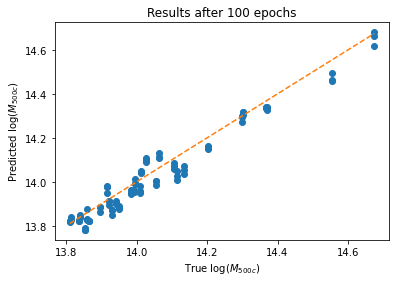


- **How did my model's loss improve with time?** Try plotting epochs `np.arange(epochs)` vs. loss `hist.history['loss']` to see how your model's loss decreased with time.  You should be aware:  when you start training again, you pick up where your model left off.  If you want to "reset" your model to epoch 0 and random weights, you should run the cells to make and compile the model again.


- **Why didn't we use the validation data?** The validation data isn't used in this tutorial, but it's available if you'd like to explore methods for preventing overfitting.  Try passing the validation data to your model fit like this `hist = model.fit(train_X, train_Y, validation_data = (val_X, val_Y), batch_size=batch_size, verbose=True, epochs=epochs)` .  While this training scheme will never use your validation data for improving the model, it will return validation loss.  So, now you can also plot `np.arange(epochs)` vs. loss `hist.history['val_loss']` to see how your validation loss decreases with time.  Validation loss can be a useful tool in identifying whether a model has [overfit](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).


- **Can I try a different model?  I think the results could be improved.** Yes!  You can try adding layers, swapping out the max pooling for average pooling, changing the activation functions, swapping out the loss function, or trying a different optimizer or learning rate.  Experiment and see what model changes give the best results.


- **I want to test my model on my training data!** No. You will convince yourself that your results are much better than they actually are.  Always keep your training, validation, and testing sets completely separate!

## About this Notebook

**Author:** Michelle Ntampaka, Data Scientist, mntampaka@stsci.edu
**Updated On:** 2021-10-01

## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](??)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)



***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 

/home/wbc/AuhUf/apps/anaconda/anaconda3/envs/hack2/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 0.0718
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 0.0199
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.1277
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step - loss: 0.0577
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.0921
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 0.0546
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.0354
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step - loss: 0.0252
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.0309
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 0.0362
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0337
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 166us/step - loss: 0.0161
Epoch 13/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.0327
Epoch 14/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step - loss: 0.0183
Epoch 15/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 

2024-09-03 14:24:38.743721: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 0.0249
Epoch 30/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step - loss: 0.0322
Epoch 31/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.0215
Epoch 32/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - loss: 0.0196
Epoch 33/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0277
Epoch 34/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step - loss: 0.0178
Epoch 35/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0234
Epoch 36/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 153us/step - loss: 0.0121
Epoch 37/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0190
Epoch 38/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step - loss: 0.0169
Epoch 39/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0211
Epoch 40/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step - loss: 0.0251
Epoch 41/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0161
Epoch 42/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 157us/step - loss: 0.0093
Epoch 43/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 105

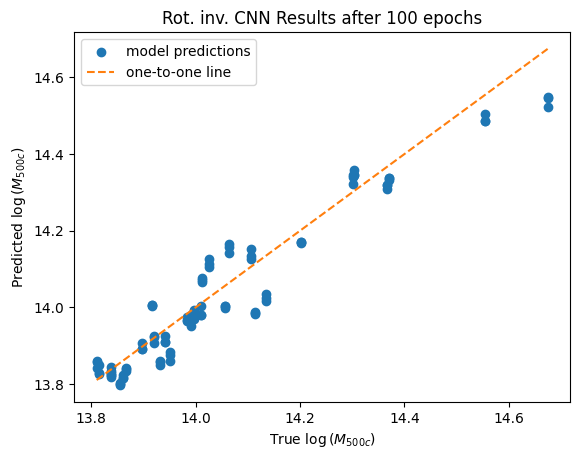

In [2]:
%matplotlib inline
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

# You will need to set this path according to where you've stored the data set on your machine!
filename = "/data/wbc/A3net/hack2/" + 'cluster_TNG_data.fits'
hdul = fits.open(filename)

image_size = hdul[1].data.shape[1]

train_ind = np.argwhere(hdul[2].data['train'] == 1)
train_X = hdul[1].data[train_ind].reshape(-1, image_size, image_size, 1)
train_Y = hdul[2].data['log_M500'][train_ind]

val_ind = np.argwhere(hdul[2].data['validate'] == 1)
val_X = hdul[1].data[val_ind].reshape(-1, image_size, image_size, 1)
val_Y = hdul[2].data['log_M500'][val_ind]

test_ind = np.argwhere(hdul[2].data['test'] == 1)
test_X = hdul[1].data[test_ind].reshape(-1, image_size, image_size, 1)
test_Y = hdul[2].data['log_M500'][test_ind]

norm = np.nanmin(hdul[2].data['log_M500'])
train_Y -= norm
val_Y -= norm
test_Y -= norm

input_shape = (image_size, image_size, 1)

# 数据增强
datagen = ImageDataGenerator(
    rotation_range=300,  # 随机旋转的角度范围
    width_shift_range=0.2,  # 随机水平移动的范围
    height_shift_range=0.2,  # 随机垂直移动的范围
    shear_range=0.2,  # 剪切强度
    zoom_range=0.2,  # 随机缩放的范围
    horizontal_flip=True,  # 是否随机水平翻转图像
    fill_mode='nearest'  # 填充新创建像素的方法
)

# 应用数据增强
batch_size = 16  # 根据内存情况调整
train_X_augmented = datagen.flow(train_X, train_Y, batch_size=batch_size)

model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))  # 使用平均池化代替最大池化
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.1))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam())

epochs = 100
hist = model.fit(train_X_augmented, steps_per_epoch=len(train_X) // batch_size, epochs=epochs, verbose=True)

prediction = model.predict(test_X, verbose=0, batch_size=batch_size).flatten()
# Remember when we subtracted off the min in an earlier cell?  In the next line, we're putting it back in!
plt.scatter(test_Y + norm, prediction + norm, c='C0', label='model predictions')
x = np.linspace(np.min(test_Y+norm), np.max(test_Y+norm), 100)
plt.plot(x, x, ls='--', c='C1', label='one-to-one line')
plt.xlabel('True ' + r'$\log\left(M_{500c}\right)$')
plt.ylabel('Predicted ' + r'$\log\left(M_{500c}\right)$')
plt.title('Rot. inv. CNN Results after {:.0f} epochs'.format(epochs))
plt.legend()
plt.show()